In [22]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

# A. Generate Data

In [23]:
#!Rscript generate_data.R --N_data=10000

# B. Train Model

In [24]:
class PhiThreshDataset(Dataset):
    def __init__(self, data_dir):
        self.phi_dir = os.path.join(data_dir, 'Phi_mat')
        self.v_thresh_dir = os.path.join(data_dir, 'v_thresh')
        
        self.phi_files = [f for f in os.listdir(self.phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
        self.v_thresh_files = [f for f in os.listdir(self.v_thresh_dir) if f.startswith('v_thresh_') and f.endswith('.txt')]

    def __len__(self):
        return len(self.phi_files)

    def __getitem__(self, idx):
        phi_file = os.path.join(self.phi_dir, self.phi_files[idx])
        phi = np.loadtxt(phi_file)
        
        v_thresh_file = os.path.join(self.v_thresh_dir, self.v_thresh_files[idx])
        v_thresh = np.loadtxt(v_thresh_file)

        return torch.tensor(phi, dtype=torch.float32), torch.tensor(v_thresh, dtype=torch.float32)

In [25]:
def get_data_loaders(data_dir, batch_size=32, test_size=0.2):
    dataset = PhiThreshDataset(data_dir)
    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=42)
    
    train_set = torch.utils.data.Subset(dataset, train_indices)
    test_set = torch.utils.data.Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [26]:
class PhiNet(nn.Module):
    def __init__(self, input_size):
        super(PhiNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = (torch.sigmoid(self.fc3(x)) + 1)*0.5 # Busquem el rang (0.5, 1)
        return x

In [27]:
def evaluate_model(model, train_loader, test_loader, criterion, verbose=True):
    model.eval()
    total_loss = 0.0
    losses_over_train = []
    with torch.no_grad():
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
            losses_over_train.append(loss.item())
    if verbose:
        print(f'Train Loss: {total_loss / len(train_loader):.4f}')
    
    total_loss = 0.0
    losses_over_test = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
            losses_over_test.append(loss.item())
    if verbose:
        print(f'Test Loss: {total_loss / len(test_loader):.4f}')
    
    return losses_over_train, losses_over_test

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", position=0, leave=True)
        for i, (inputs, targets) in progress_bar:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Running Loss: {running_loss / len(train_loader):.4f}')
        _, _ = evaluate_model(model, train_loader, test_loader, criterion)

In [28]:
data_dir = 'data'
input_size = len(np.loadtxt(os.path.join(data_dir, 'Phi_mat/Phi_mat_1.txt')))

hparams = {"batch_size": 16,
           "learning_rate": 0.001,
           "num_epochs": 10}

train_loader, test_loader = get_data_loaders(data_dir, batch_size=hparams["batch_size"])

model = PhiNet(input_size=input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])

train_model(model, train_loader, criterion, optimizer, num_epochs=hparams["num_epochs"])

Epoch 1/10: 100%|██████████| 50/50 [00:00<00:00, 206.57it/s]


Epoch [1/10], Running Loss: 0.0368
Train Loss: 0.0288
Test Loss: 0.0301


Epoch 2/10: 100%|██████████| 50/50 [00:00<00:00, 230.84it/s]


Epoch [2/10], Running Loss: 0.0274
Train Loss: 0.0262
Test Loss: 0.0298


Epoch 3/10: 100%|██████████| 50/50 [00:00<00:00, 220.70it/s]


Epoch [3/10], Running Loss: 0.0260
Train Loss: 0.0250
Test Loss: 0.0297


Epoch 4/10: 100%|██████████| 50/50 [00:00<00:00, 216.03it/s]


Epoch [4/10], Running Loss: 0.0248
Train Loss: 0.0232
Test Loss: 0.0294


Epoch 5/10: 100%|██████████| 50/50 [00:00<00:00, 223.19it/s]


Epoch [5/10], Running Loss: 0.0231
Train Loss: 0.0215
Test Loss: 0.0299


Epoch 6/10: 100%|██████████| 50/50 [00:00<00:00, 239.77it/s]


Epoch [6/10], Running Loss: 0.0218
Train Loss: 0.0201
Test Loss: 0.0306


Epoch 7/10: 100%|██████████| 50/50 [00:00<00:00, 232.14it/s]


Epoch [7/10], Running Loss: 0.0206
Train Loss: 0.0187
Test Loss: 0.0299


Epoch 8/10: 100%|██████████| 50/50 [00:00<00:00, 244.43it/s]


Epoch [8/10], Running Loss: 0.0194
Train Loss: 0.0177
Test Loss: 0.0296


Epoch 9/10: 100%|██████████| 50/50 [00:00<00:00, 235.91it/s]


Epoch [9/10], Running Loss: 0.0186
Train Loss: 0.0168
Test Loss: 0.0296


Epoch 10/10: 100%|██████████| 50/50 [00:00<00:00, 229.75it/s]


Epoch [10/10], Running Loss: 0.0178
Train Loss: 0.0158
Test Loss: 0.0287


# Evaluate Model

In [29]:
losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion)

Train Loss: 0.0158
Test Loss: 0.0287


## v distribution

### Training Data

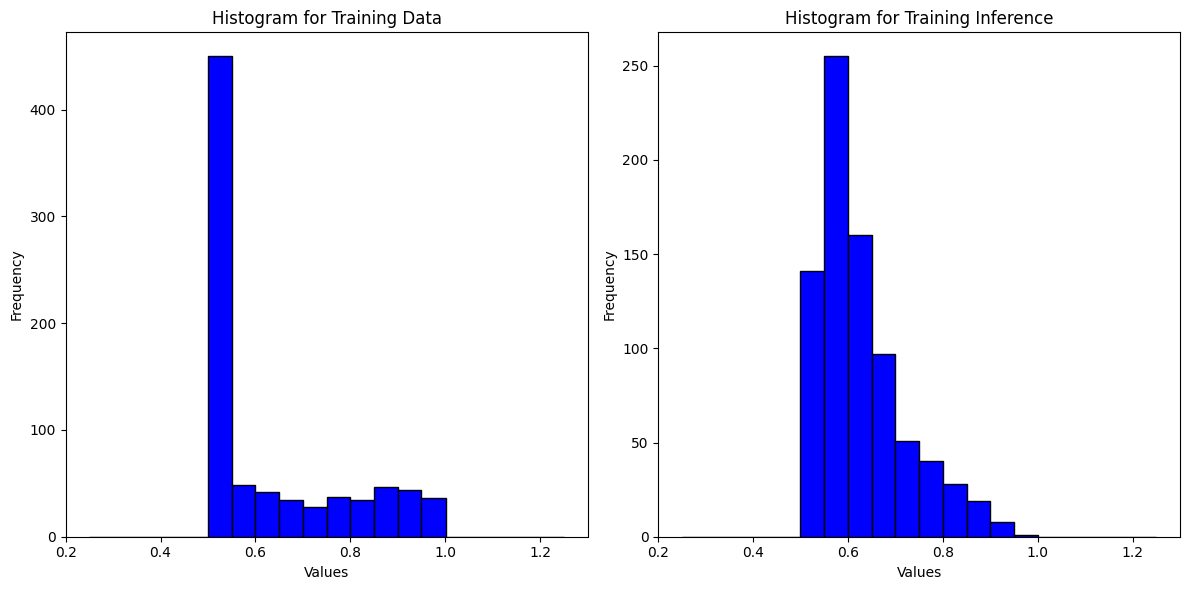

In [30]:
model.eval()

with torch.no_grad():
    train_loader_v = []
    train_infer_v = []
    for inputs, targets in train_loader:
        train_loader_v += targets.numpy().squeeze().tolist()
        train_infer_v += model(inputs).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(train_loader_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Training Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(train_infer_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Training Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

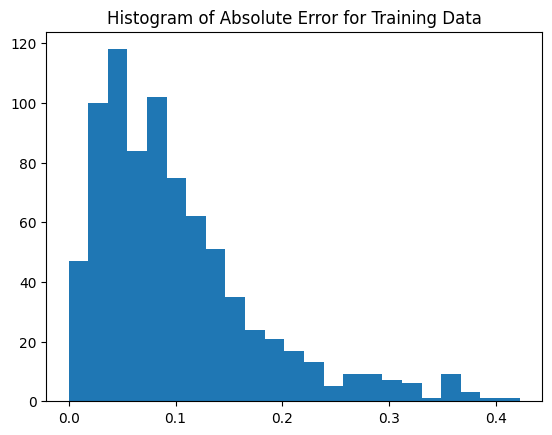

In [31]:
plt.hist(np.abs(np.array(train_loader_v) - np.array(train_infer_v)), bins='auto')
plt.title("Histogram of Absolute Error for Training Data")
plt.show()

### Test Data

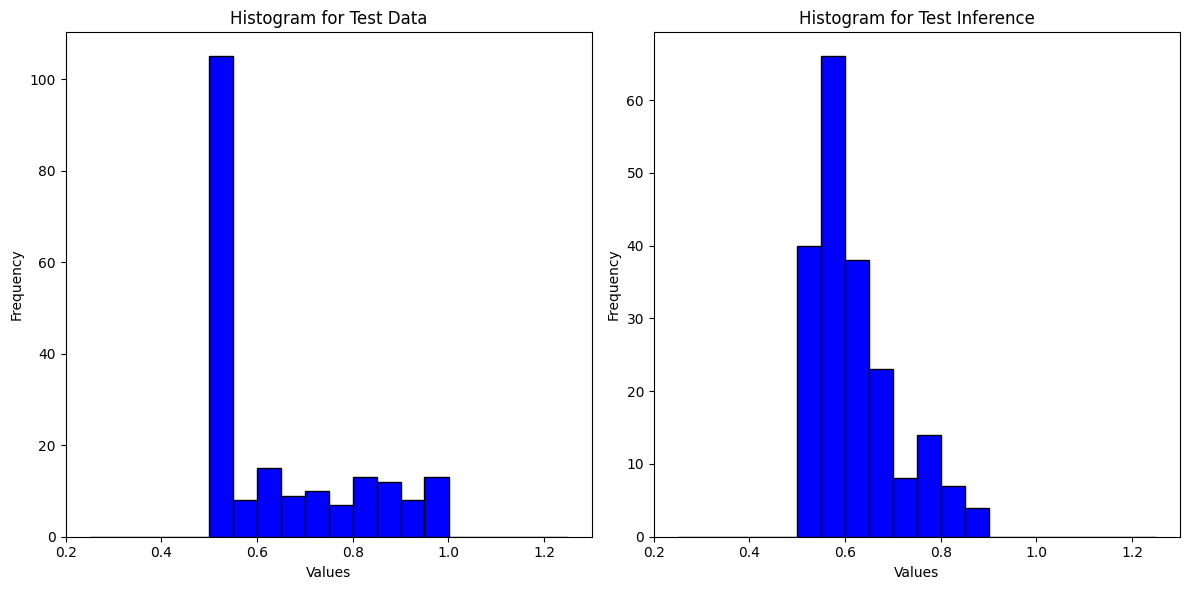

In [32]:
model.eval()

with torch.no_grad():
    test_loader_v = []
    test_infer_v = []
    for inputs, targets in test_loader:
        test_loader_v += targets.numpy().squeeze().tolist()
        test_infer_v += model(inputs).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(test_loader_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Test Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(test_infer_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Test Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

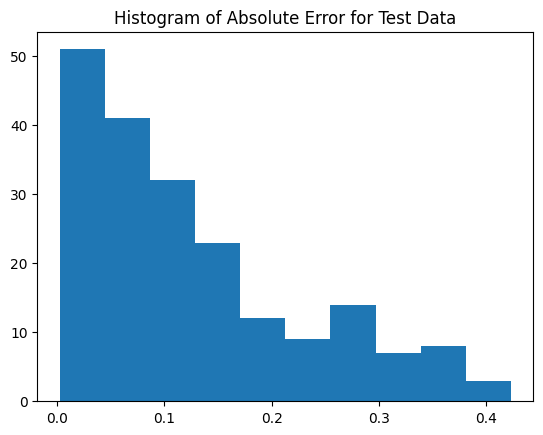

In [33]:
plt.hist(np.abs(np.array(test_loader_v) - np.array(test_infer_v)), bins='auto')
plt.title("Histogram of Absolute Error for Test Data")
plt.show()

## FDR and TPR

In [34]:
data_dir = 'data'
phi_dir = os.path.join(data_dir, 'Phi_mat')
true_actives_dir = os.path.join(data_dir, 'true_actives')

phi_data = [np.loadtxt(os.path.join(phi_dir, f)) 
            for f in os.listdir(phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
true_actives_data = [np.loadtxt(os.path.join(true_actives_dir, f), dtype=int) - 1  # We substract 1 as they are R indices (starting from 1)
                     for f in os.listdir(true_actives_dir) if f.startswith('true_actives_') and f.endswith('.txt')]

FDRs = []  # or FDPs
TPRs = []  # or TPPs
for phi, true_actives in zip(phi_data, true_actives_data):
    with torch.no_grad():
        v = model(torch.Tensor(phi)).numpy()[0]
    selected = np.where(phi > v)[0]
    selected_actives = np.intersect1d(selected, true_actives, assume_unique=True)
    selected_null = np.setdiff1d(selected, selected_actives, assume_unique=True)
    FDRs.append(len(selected_null)/max(len(selected), 1))
    TPRs.append(len(selected_actives)/max(len(true_actives), 1))

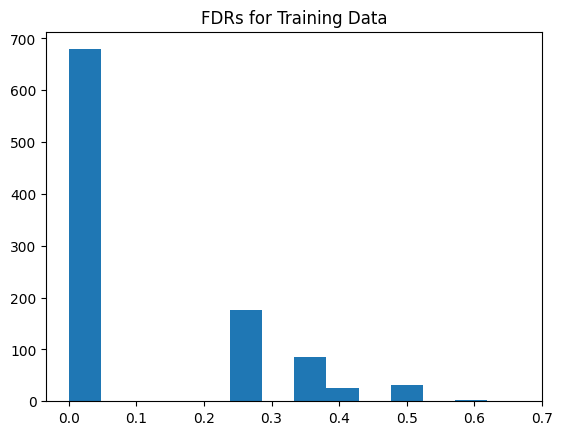

In [35]:
plt.hist(FDRs, bins='auto')
plt.title("FDRs for Training Data")
plt.show()

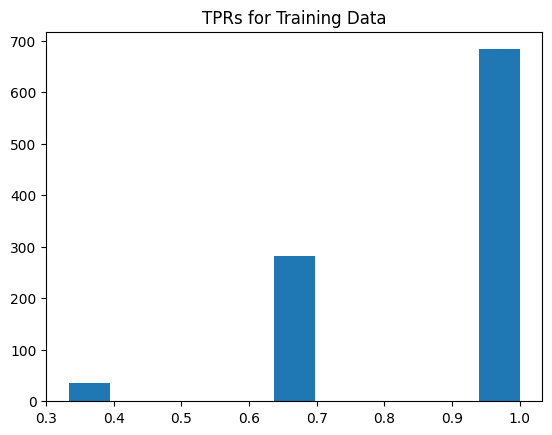

In [36]:
plt.hist(TPRs, bins='auto')
plt.title("TPRs for Training Data")
plt.show()